### Face-Detection OpenCV

In [ ]:
!pip install opencv-python onnxruntime numpy matplotlib

In [18]:
import cv2
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt
import os

In [19]:
model_path = "version-RFB-320.onnx"

face_detector = ort.InferenceSession(model_path)

In [20]:
def scale(box):
    width = box[2] - box[0]
    height = box[3] - box[1]
    maximum = max(width, height)
    dx = int((maximum - width)/2)
    dy = int((maximum - height)/2)

    bboxes = [box[0] - dx, box[1] - dy, box[2] + dx, box[3] + dy]
    return bboxes

In [21]:
def nms(boxes, scores, iou_threshold):
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        keep_indices = np.where(ious < iou_threshold)[0]

        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes


In [22]:
def compute_iou(box, boxes):
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    iou = intersection_area / union_area

    return iou

In [23]:

def predict(width, height, confidences, boxes, prob_threshold, iou_threshold=0.3, top_k=-1):
    boxes = boxes[0]
    confidences = confidences[0]
    picked_box_probs = []
    picked_labels = []
    for class_index in range(1, confidences.shape[1]):
        probs = confidences[:, class_index]
        mask = probs > prob_threshold
        probs = probs[mask]
        if probs.shape[0] == 0:
            continue
        subset_boxes = boxes[mask, :]
        box_probs = np.concatenate([subset_boxes, probs.reshape(-1, 1)], axis=1)
        box_probs = box_probs[nms(box_probs[:, :4], box_probs[:, 4], iou_threshold)]
        picked_box_probs.append(box_probs)
        picked_labels.extend([class_index] * box_probs.shape[0])
    if not picked_box_probs:
        return np.array([]), np.array([]), np.array([])
    picked_box_probs = np.concatenate(picked_box_probs)
    picked_box_probs[:, 0] *= width
    picked_box_probs[:, 1] *= height
    picked_box_probs[:, 2] *= width
    picked_box_probs[:, 3] *= height
    if top_k > 0:
        box_probs = picked_box_probs[:top_k]
        box_labels = picked_labels[:top_k]
    else:
        box_probs = picked_box_probs
        box_labels = picked_labels
    return box_probs[:, :4].astype(np.int32), box_labels, box_probs[:, 4]

In [24]:

def faceDetector(orig_image, threshold=0.7):
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240))
    image_mean = np.array([127, 127, 127])
    image = (image - image_mean) / 128
    image = np.transpose(image, [2, 0, 1])
    image = np.expand_dims(image, axis=0)
    image = image.astype(np.float32)

    input_name = face_detector.get_inputs()[0].name
    confidences, boxes = face_detector.run(None, {input_name: image})
    boxes, labels, probs = predict(orig_image.shape[1], orig_image.shape[0], confidences, boxes, threshold)
    return boxes, labels, probs

In [25]:
def process_image(image_path, title):
    orig_image = cv2.imread(image_path)
    boxes, labels, probs = faceDetector(orig_image)

    color = (255, 128, 0)  # BGR color
    for i in range(boxes.shape[0]):
        box = scale(boxes[i, :])
        cv2.rectangle(orig_image, (box[0], box[1]), (box[2], box[3]), color, 4)

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{title}\nDetected {len(boxes)} faces")
    plt.show()

    print(f"Detected {len(boxes)} faces")
    print(f"Confidence scores: {probs}")

    for i, box in enumerate(boxes):
        face = orig_image[box[1]:box[3], box[0]:box[2]]
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.title(f"Face {i+1}, Confidence: {probs[i]:.2f}")
        plt.axis('off')
        plt.show()

In [26]:
image_directory = "test_images"

scenarios = [
    ("single_face.jpeg", "Single face"),
    ("two_faces.jpeg", "Two faces"),
    ("multiple_faces.jpeg", "Multiple faces"),
    ("no_face.jpeg", "No faces (landscape)")
]


Processing image: Single face
Image file not found: test_images/single_face.jpeg

Processing image: Two faces
Image file not found: test_images/two_faces.jpeg

Processing image: Multiple faces


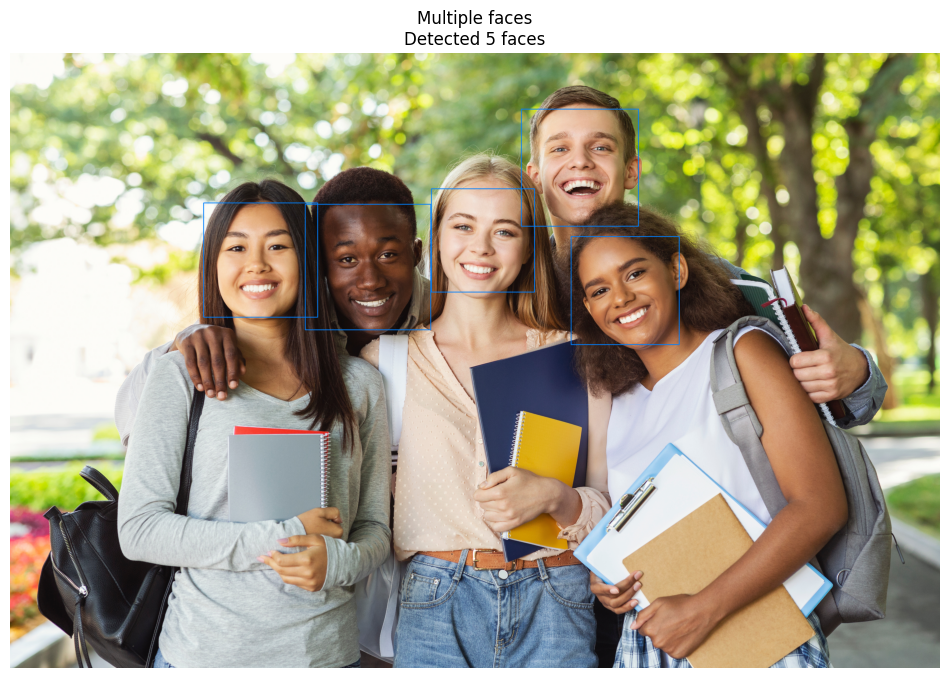

Detected 5 faces
Confidence scores: [0.99970394 0.99966145 0.9993593  0.99922967 0.9960525 ]


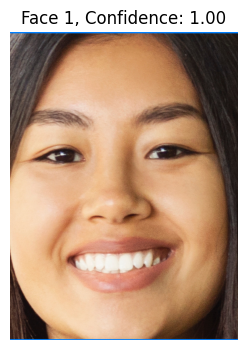

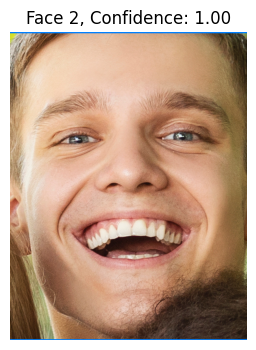

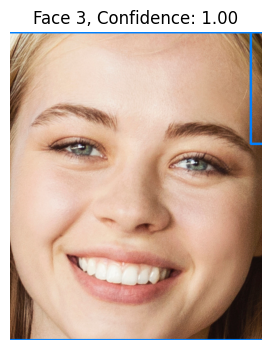

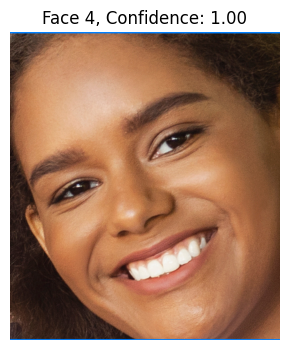

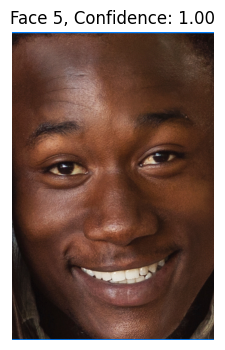


Processing image: No faces (landscape)


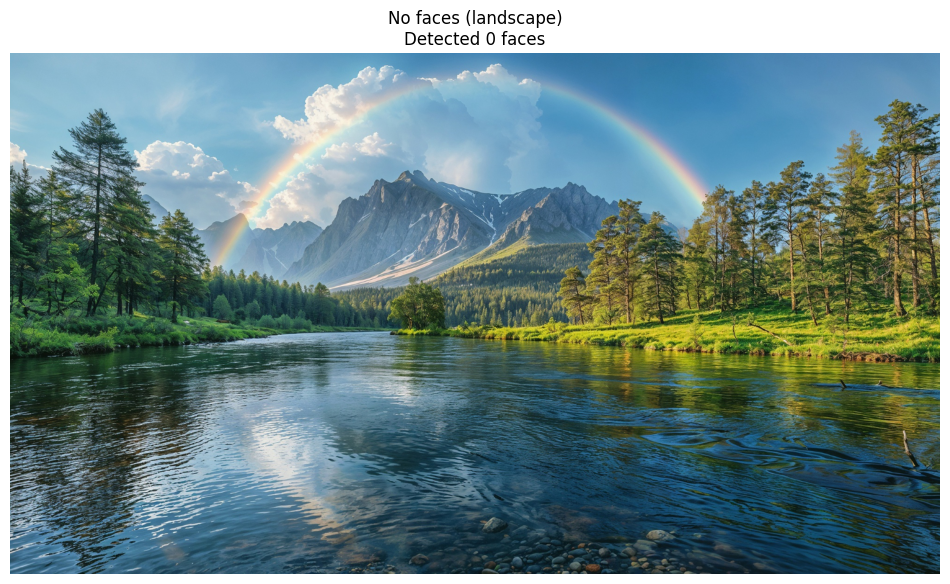

Detected 0 faces
Confidence scores: []


In [27]:
for filename, title in scenarios:
    print(f"\nProcessing image: {title}")
    image_path = os.path.join(image_directory, filename)
    if os.path.exists(image_path):
        process_image(image_path, title)
    else:
        print(f"Image file not found: {image_path}")